In [2]:
import jax.numpy as jnp
import jax.random as jr
from sklearn.neighbors import KernelDensity
from itertools import count
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")
from dynamax.hidden_markov_model import LinearRegressionHMM
from jax import vmap
from sklearn.metrics import r2_score
from sklearn import metrics
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import acme
import h5py
import BehavUtils as butils
from sklearn.mixture import GaussianMixture

cols_mouse = sns.color_palette(np.array(["#5E3C18", "#F5993D", "#A8612A", 
                                        sns.desaturate("#F5993D", 0.3), 
                                        'orange', '#FBA984', "#940393", '#FE9E47',
                                        "#e9b7e3", "#cf60f3", "#5a3386",
                                        sns.desaturate("#ff66b2", 0.5), '#FF8C80']))

my_cmap = ListedColormap(sns.color_palette(cols_mouse).as_hex())

def generate_synthetic_data(data, bandwidth_scale = 0.2):
    synthetic_data = np.zeros(data.shape)
    for i in range(data.shape[1]):
        # Reshape the data for sklearn
        column_data = data[:, i].reshape(-1, 1)

        # Estimate the bandwidth as a fraction of the data range
        bandwidth = bandwidth_scale * np.std(column_data)

        # Use KDE to fit the data
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
        kde.fit(column_data)

        # Sample from the KDE to create synthetic data
        synthetic_data[:, i] = kde.sample(n_samples=data.shape[0]).flatten()
        
    return synthetic_data


def generate_synthetic_data_gmm_optimized(
    data, 
    max_components=20, 
    covariance_type='full', 
    random_state=42, 
    verbose=False,
    tolerance=1e-3
):
    """
    Generates synthetic data using Gaussian Mixture Models (GMM) with optimizations for large datasets.
    
    Parameters:
    - data (np.ndarray or pd.DataFrame): Original data with shape (n_samples, n_features).
    - max_components (int): Maximum number of GMM components to try for model selection.
    - covariance_type (str): Type of covariance parameters ('full', 'tied', 'diag', 'spherical').
    - random_state (int): Seed for reproducibility.
    - verbose (bool): If True, prints progress and selected number of components.
    - tolerance (float): Threshold for the minimum improvement in BIC to continue increasing components.
    
    Returns:
    - synthetic_data (np.ndarray): Generated synthetic data with the same shape as input data.
    - gmm (GaussianMixture): Fitted GMM model.
    """
    # Ensure data is a NumPy array
    if isinstance(data, pd.DataFrame):
        data = data.values
    elif not isinstance(data, np.ndarray):
        raise ValueError("Input data must be a NumPy array or a Pandas DataFrame.")
    
    n_samples, n_features = data.shape
    
    # Initialize variables to store BIC scores and models
    bic_scores = []
    models = []
    
    # Iterate over the number of components to find the optimal one
    for n in range(1, max_components + 1):
        gmm = GaussianMixture(
            n_components=n, 
            covariance_type=covariance_type, 
            random_state=random_state,
            n_init=3,  # Reduced number of initializations for speed
            max_iter=200  # Default max iterations
        )
        gmm.fit(data)
        bic = gmm.bic(data)
        bic_scores.append(bic)
        models.append(gmm)
        if verbose:
            print(f"Fitted GMM with {n} components. BIC: {bic:.2f}")
    
    # Plot BIC scores
    plt.figure(figsize=(5,4))
    plt.plot(np.arange(max_components)+1, bic_scores, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('BIC Score')
    plt.axvline(3)

    # Select the model with the lowest BIC
    optimal_n = 3#np.argmin(bic_scores) + 1
    optimal_gmm = models[optimal_n]
    
    if verbose:
        print(f"\nOptimal number of components selected: {optimal_n}")
    
    # Generate synthetic data
    synthetic_data, _ = optimal_gmm.sample(n_samples)
    
    return synthetic_data, optimal_gmm


def plot_feature_distributions(original, synthetic, feature_names=None, n_features=5):
    """
    Plots the distribution of each feature for original and synthetic data.
    
    Parameters:
    - original (np.ndarray): Original dataset.
    - synthetic (np.ndarray): Synthetic dataset.
    - feature_names (list): Optional list of feature names.
    - n_features (int): Number of features to plot.
    """
    if feature_names is None:
        feature_names = [f"Feature {i+1}" for i in range(original.shape[1])]
    fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize=(5, 6))
    for i in range(n_features):
        
        sns.kdeplot(original[:, i], label='Original', shade=True, ax = ax.flat[i], color = 'gray')
        sns.kdeplot(synthetic[:, i], label='Synthetic', shade=True, ax = ax.flat[i], color = 'orange')
        ax.flat[i].set_xlabel(f'{feature_names[i]}')
        ax.flat[i].set_ylabel('Density')
        if i == 0:
            ax.flat[i].legend(frameon = False, handlelength = 0, labelcolor = 'linecolor', fontsize = 10)
        ax.flat[i].set_xticks([])
        ax.flat[i].set_yticks([])
    plt.tight_layout()

    sns.despine()

# Define feature names if available
feature_names = ['Pupil Size', 'Eye Mov', 'Nose Mov', 'Eye [x]', 'Eye [y]', 'Nose [x]', 'Nose [y]', 'Whiskers [x]', 'Whiskers [y]']

newOrder_mouse = np.array([0, 2, 3, 1, 4, 5, 6, 7])


def fit_model_cv(X_cv, y_cv, X_val, y_val, nStates, covariate_dim, emission_dim, params, param_props):
    
    # Initialize our MSLR.
    mslr = LinearRegressionHMM(nStates, covariate_dim, emission_dim)
    test_params, lps = mslr.fit_em(params, param_props, y_cv, inputs=X_cv, num_iters = 20)
    
    if np.sum(np.isnan(lps)):
        # Initialize our MSLR.
        mslr = LinearRegressionHMM(nStates, covariate_dim, emission_dim)
        # To fit the model, give it a batch of emissions and a batch of corresponding inputs
        test_params, lps = mslr.fit_sgd(params, param_props, y_cv, inputs=X_cv, num_epochs = 2000)
    if len(lps) == 0:
        lps = np.array([0, 0])
    # Compute the most likely states
    most_likely_states = mslr.most_likely_states(test_params, y_val, inputs = X_val)
    most_likely_states = np.array(most_likely_states)

    # Predict the emissions given the true states
    As = test_params.emissions.weights[most_likely_states]
    bs = test_params.emissions.biases[most_likely_states]
    y_pred= vmap(lambda x, A, b: A @ x + b)(X_val, As, bs)

    return r2_score(y_pred, y_val)


def find_similar_states(true_states, most_likely_states):
    """
    Find the normalized mutual information between true states and most likely states.

    Parameters:
    - true_states: array-like, true state labels
    - most_likely_states: array-like, predicted state labels

    Returns:
    - cors: 2D NumPy array, matrix of normalized mutual information values
    """
    num_states = np.max(true_states) + 1
    
    # Convert true_states to pandas Series and one-hot encode
    true_series = pd.Series(true_states)
    true_ohe = pd.get_dummies(true_series).values
    
    # Convert most_likely_states to pandas Series and one-hot encode
    pred_series = pd.Series(most_likely_states)
    pred_ohe = pd.get_dummies(pred_series).values
    
    # Initialize the correlation matrix
    cors = np.zeros((num_states, num_states))
    
    # Compute normalized MI for each pair of states
    for ii in range(num_states):
        for jj in range(num_states):
            cors[ii, jj] = np.corrcoef(true_ohe[:, ii], pred_ohe[:, jj])[0,1]
    return cors


/tmp/ipykernel_1122573/1594448806.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cols_mouse = sns.color_palette(np.array(["#5E3C18", "#F5993D", "#A8612A",


In [3]:
# Load the data
dats_train = np.load('Predictors_emissions_mouse_newDLC_concat_train_40pad_nonScaled.npz', allow_pickle = True)
inputs_train = dats_train['predictors']
outputs_train = dats_train['emissions']

inputs_train = inputs_train[:,np.arange(inputs_train.shape[1]) != 1]

# First set some global constants
num_timesteps, covariate_dim = inputs_train.shape
emission_dim = 1
nSplits = 5
nReps = 10
btscv = butils.BlockingTimeSeriesSplit(n_splits=nSplits)

# Initialize server, to parallelize.
acme.cluster_cleanup()
client = acme.esi_cluster_setup(partition="8GBXS", n_jobs=int(nSplits*nReps),
                                 n_jobs_startup=10, timeout=60000, interactive_wait=1)

# Simulate data from a "true" model with the same parameters as in the main text.
num_states_true = 5
stickiness = 42
concentration = 34

# Initialize keys for random number generation; we fixed the seeds for reproducibility.
#keys = map(jr.PRNGKey, count())
#SEED = next(keys)
valid_seeds = np.load('ValidSeeds_Mouse_11112024.npy')
SEED = jr.PRNGKey(valid_seeds[0])


def generate_synthetic_hmm_data(num_states, covariate_dim, emission_dim, stickiness, concentration, num_timesteps, inputs, seed):
    hmm = LinearRegressionHMM(num_states, covariate_dim, emission_dim,
                              transition_matrix_concentration = concentration, transition_matrix_stickiness = stickiness)
    params, _ = hmm.initialize(seed)
    states, emissions = hmm.sample(params, seed, num_timesteps, inputs=inputs)
    true_lp = hmm.marginal_log_prob(params, emissions, inputs = inputs)
    return states, emissions, params, true_lp

true_states, emissions, true_params, true_lp = generate_synthetic_hmm_data(num_states_true, covariate_dim, emission_dim, stickiness, concentration, num_timesteps, inputs_train, SEED)

/gs/home/tlaieboriaa/.conda/envs/Cluster-GLMHMM3/lib/python3.9/site-packages/acme/dask_helpers.py:765: RuntimeWarning: <cluster_cleanup> No dangling clients or clusters found.
  inspect.currentframe().f_lineno)


<slurm_cluster_setup> Requested job-count 50 exceeds `n_jobs_startup`: waiting for 10 jobs to come online, then proceed


<slurm_cluster_setup> SLURM workers ready: 50/None 	[elapsed time 00:17 | timeout at :40:00]


<slurm_cluster_setup> Cluster dashboard accessible at http://10.100.32.3:8787/status


In [4]:
internal_states = np.arange(2,11)
X_cv_fin, X_val_fin, y_cv_fin, y_val_fin = [],[], [], []
r2_cv = np.zeros((internal_states.shape[0], int(nReps * nSplits)))
for ii, num_states in enumerate(internal_states):
    
    X_cv_list = []
    X_val_list = []
    y_cv_list = []
    y_val_list = []
    
    for s in range(nReps):
        for cv_index, val_index in btscv.split(inputs_train, emissions):

            # Split data into cross-validation and validation sets
            X_cv, X_val = inputs_train[cv_index, :], inputs_train[val_index, :]
            y_cv, y_val = emissions[cv_index], emissions[val_index]
            y_cv = y_cv.reshape(-1, 1)
            y_val = y_val.reshape(-1, 1)

            # Append cross-validation and validation data to lists
            X_cv_list.append(X_cv)
            X_val_list.append(X_val)
            y_cv_list.append(y_cv)
            y_val_list.append(y_val)
        X_cv_fin.append(X_cv_list)
        X_val_fin.append(X_val_list)
        y_cv_fin.append(y_cv_list)
        y_val_fin.append(y_val_list)

In [4]:
for ii, num_states in enumerate(internal_states):
    emission_dims, covariate_dims, paramss, param_propss, keyss, num_statess = [], [], [], [], [], []
    for s in range(nReps):
        for cv_counter in range(nSplits):
            
            SEED_cv = jr.PRNGKey(valid_seeds[int(s*cv_counter)])
            #SEED_cv = next(keys)

            mslr = LinearRegressionHMM(num_states, covariate_dim, emission_dim)

            init_params, param_props = mslr.initialize(SEED_cv)
            
            keyss.append(SEED_cv)
            paramss.append(init_params)
            param_propss.append(param_props)
            num_statess.append(num_states)
            covariate_dims.append(covariate_dim)
            emission_dims.append(emission_dim)
            
    # Evaluate MSLR models in parallel
    pmap = acme.ParallelMap(fit_model_cv, X_cv_fin[ii], y_cv_fin[ii], X_val_fin[ii], y_val_fin[ii], num_statess, covariate_dims, emission_dims, paramss, param_propss, 
                            n_inputs=len(paramss), setup_timeout=1)

    with pmap as p:
        results = p.compute()

    for rr, fname in enumerate(results):
        with h5py.File(fname, 'r') as f:
            r2_cv[ii, rr] = float(np.array(f['result_0']))
    print(ii+internal_states[0])

<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
<ParallelMap> INFO: Preparing 50 parallel calls of `fit_model_cv` using 50 workers
INFO:<ParallelMap>:Preparing 50 parallel calls of `fit_model_cv` using 50 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
100% |██████████| 50/50 [00:18<00:00]
<ParallelMap> INFO: SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093219-753320
INFO:<ParallelMap>:SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093219-753320


2


<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
<ParallelMap> INFO: Preparing 50 parallel calls of `fit_model_cv` using 50 workers
INFO:<ParallelMap>:Preparing 50 parallel calls of `fit_model_cv` using 50 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
100% |██████████| 50/50 [00:02<00:00]
<ParallelMap> INFO: SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093335-891397
INFO:<ParallelMap>:SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093335-891397


3


<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
<ParallelMap> INFO: Preparing 50 parallel calls of `fit_model_cv` using 50 workers
INFO:<ParallelMap>:Preparing 50 parallel calls of `fit_model_cv` using 50 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
100% |██████████| 50/50 [00:06<00:00]
<ParallelMap> INFO: SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093432-578271
INFO:<ParallelMap>:SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093432-578271


4


<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
<ParallelMap> INFO: Preparing 50 parallel calls of `fit_model_cv` using 50 workers
INFO:<ParallelMap>:Preparing 50 parallel calls of `fit_model_cv` using 50 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
100% |██████████| 50/50 [00:02<00:00]
<ParallelMap> INFO: SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093533-030546
INFO:<ParallelMap>:SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093533-030546


5


<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
<ParallelMap> INFO: Preparing 50 parallel calls of `fit_model_cv` using 50 workers
INFO:<ParallelMap>:Preparing 50 parallel calls of `fit_model_cv` using 50 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
100% |██████████| 50/50 [00:08<00:00]
<ParallelMap> INFO: SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093631-694454
INFO:<ParallelMap>:SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093631-694454


6


<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
<ParallelMap> INFO: Preparing 50 parallel calls of `fit_model_cv` using 50 workers
INFO:<ParallelMap>:Preparing 50 parallel calls of `fit_model_cv` using 50 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
100% |██████████| 50/50 [00:07<00:00]
<ParallelMap> INFO: SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093737-283570
INFO:<ParallelMap>:SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093737-283570


7


<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
<ParallelMap> INFO: Preparing 50 parallel calls of `fit_model_cv` using 50 workers
INFO:<ParallelMap>:Preparing 50 parallel calls of `fit_model_cv` using 50 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
100% |██████████| 50/50 [00:07<00:00]
<ParallelMap> INFO: SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093840-407731
INFO:<ParallelMap>:SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093840-407731


8


<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
<ParallelMap> INFO: Preparing 50 parallel calls of `fit_model_cv` using 50 workers
INFO:<ParallelMap>:Preparing 50 parallel calls of `fit_model_cv` using 50 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
100% |██████████| 50/50 [00:08<00:00]
<ParallelMap> INFO: SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093950-359548
INFO:<ParallelMap>:SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-093950-359548


9


<ParallelMap> INFO: Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
INFO:<ParallelMap>:Attaching to global parallel computing client <Client: 'tcp://10.100.32.3:41259' processes=50 threads=50, memory=372.50 GiB>
<ParallelMap> INFO: Preparing 50 parallel calls of `fit_model_cv` using 50 workers
INFO:<ParallelMap>:Preparing 50 parallel calls of `fit_model_cv` using 50 workers
<ParallelMap> INFO: Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
INFO:<ParallelMap>:Log information available at /cs/slurm/tlaieboriaa/tlaieboriaa_20241112-093101
100% |██████████| 50/50 [00:09<00:00]
<ParallelMap> INFO: SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-094101-421047
INFO:<ParallelMap>:SUCCESS! Finished parallel computation. Results have been saved to /cs/home/tlaieboriaa/ACME_20241112-094101-421047


10


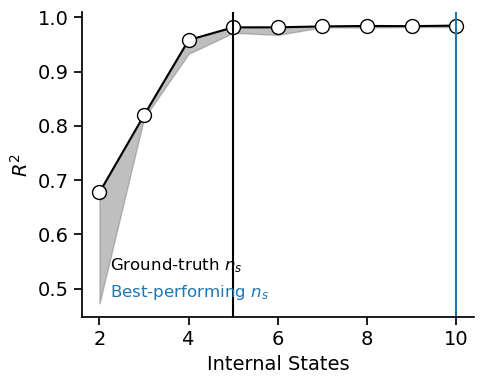

In [35]:
max_r2_cv = np.nanmax(r2_cv, axis=1)  # calculate the max along axis=1
shaded_r2_cv = np.nanpercentile(r2_cv, 90, axis=1)  # calculate the standard deviation along axis=1
plt.figure(figsize = (5, 4))
plt.plot(internal_states, max_r2_cv, color = 'black', marker = 'o', mfc = 'white', ms = 10)  # plot the max r2_cv
plt.axvline(num_states_true, color = 'black', label = r"Ground-truth $n_s$")
plt.axvline(np.argmax(max_r2_cv) + internal_states[0], label = r"Best-performing $n_s$")
plt.fill_between(internal_states, shaded_r2_cv, max_r2_cv, color='gray', alpha=0.5)
plt.xlabel('Internal States', fontsize = 14)
plt.ylabel(r"$R^2$", fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(handlelength = 0, frameon = False, labelcolor = 'linecolor',fontsize = 12)
sns.despine()
plt.tight_layout()
plt.savefig('Results/CV_Curve_Synthetic_12112024.svg', transparent = True)

Text(0.5, 0, '# internal states')

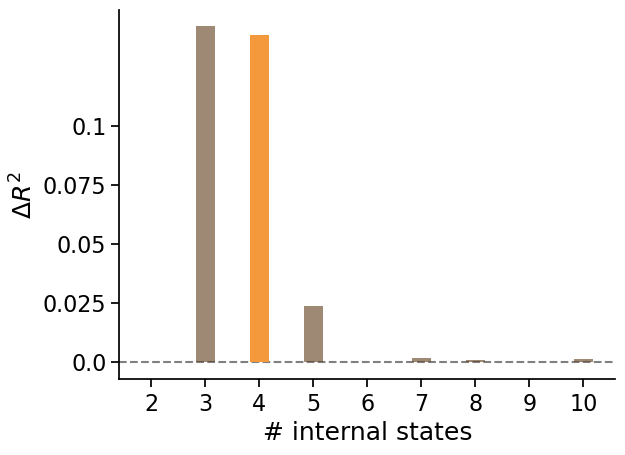

In [6]:
diffs = np.diff(max_r2_cv)
diffs = np.concatenate([[0], diffs])


plt.bar(x = internal_states, height = diffs, color = cols_mouse[0], width = 0.35, alpha = 0.6)
plt.bar(x = [internal_states[2]], height = [diffs[2]], color = cols_mouse[1], width = 0.35, alpha = 1)

plt.axhline(0, ls = '--', color = 'gray', zorder = -1)
sns.despine()
plt.ylabel(r'$\Delta R^2$', fontsize = 18)
plt.xticks(internal_states, internal_states, fontsize = 16)
plt.yticks(np.linspace(0, 0.1, 5), np.linspace(0, 0.1, 5).astype(np.float16), fontsize = 16)
plt.xlabel('# internal states', fontsize = 18)
#plt.savefig('Results/Derivative_CVR2_NumStates_07112024.svg', transparent = True)

Mouse: Computing pairwise Jensen-Shannon Divergence...
Mouse: Performing 200 surrogate shuffles...


Shuffling: 100%|██████████| 200/200 [00:01<00:00, 163.72it/s]


Mouse: Percentile threshold = 0.1388
Mouse: Number of clusters below threshold: 5
Cluster 1: A, E, F, I
Cluster 2: B, D, H
Cluster 3: C
Cluster 4: J
Cluster 5: G


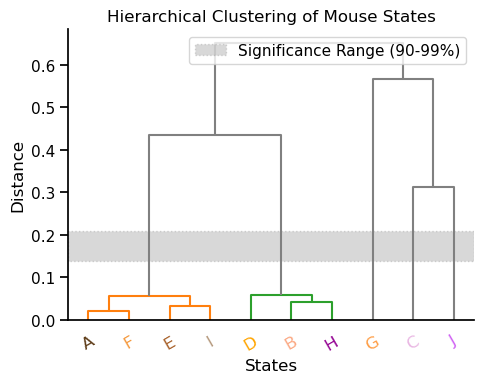

In [32]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform, jensenshannon
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import itertools
from functools import partial
import os
from tqdm import tqdm  # For progress bars
import seaborn as sns
import cmcrameri as cmc

# Ensure reproducibility
np.random.seed(42)

def hierarchical_clustering_single_session(
    predicted_states,
    y_test,
    all_states,
    species='Species',
    colors=None,
    n_shuff=1000,
    significance_method='percentile',
    significance_threshold_1=90,
    significance_threshold_2=99,
    metric='ks',
    num_bins=30,
    n_jobs=-1,
    ax=None
):
    """
    Performs hierarchical clustering using either KS test or JSD for 1D emission distributions.
    Includes surrogate shuffles by randomly shuffling state assignments globally across the single session.

    Parameters:
    - predicted_states: 1D array containing predicted states for the single session.
    - y_test: 2D array containing emission data for the single session.
    - all_states: Integer representing the total number of states.
    - species: String for labeling purposes.
    - colors: List or array of colors for dendrogram labels.
    - n_shuff: Number of surrogate shuffles.
    - significance_method: Method to compute significance threshold ('percentile' or 'zscore').
    - significance_threshold: Percentile value or z-score multiplier for threshold.
    - metric: 'ks' for Kolmogorov-Smirnov or 'jsd' for Jensen-Shannon Divergence.
    - num_bins: Number of bins for histogram-based distribution estimation (used for JSD).
    - n_jobs: Number of parallel jobs (-1 uses all available cores).
    - ax: Matplotlib Axes object to plot the dendrogram. If None, a new figure is created.
    """
    
    # Initialize Axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Collect emissions per state
    emissions_per_state = {state: [] for state in range(all_states)}
    
    for state in range(all_states):
        state_emissions = y_test[predicted_states == state, 0]
        if state_emissions.size > 0:
            emissions_per_state[state].extend(state_emissions)
    
    # Remove states with no data
    valid_states = [s for s, e in emissions_per_state.items() if len(e) > 0]
    state_letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']  # Extend as needed
    state_labels = [f"{state_letters[s]}" for s in valid_states]
    emissions_per_state = {s: np.array(emissions_per_state[s]) for s in valid_states}
    
    # Compute histograms for each state (assuming 1D data)
    # Combine all emissions to determine bin edges
    all_emissions = np.hstack([emissions_per_state[s] for s in valid_states])
    bin_width = 2 * (np.percentile(all_emissions, 75) - np.percentile(all_emissions, 25)) / np.power(len(all_emissions), 1/3)  # Freedman-Diaconis rule
    num_bins = max(10, int((np.max(all_emissions) - np.min(all_emissions)) / bin_width))  # Ensure at least 10 bins
    bin_edges = np.histogram_bin_edges(all_emissions, bins=num_bins)
    
    # Compute histograms for each state
    histograms = []
    for state in valid_states:
        hist, _ = np.histogram(emissions_per_state[state], bins=bin_edges, density=True)
        hist = np.nan_to_num(hist)  # Replace NaN or inf with zero
        histograms.append(hist)
    histograms = np.array(histograms)
    
    print(f"{species}: Computing pairwise Jensen-Shannon Divergence...")
    num_valid = len(valid_states)
    
    # Generate all unique pairs (i, j) where i < j
    pairs = list(itertools.combinations(range(num_valid), 2))
    
    # Define a function to compute JSD for a pair
    def compute_jsd(i, j):
        jsd = jensenshannon(histograms[i], histograms[j])**2  # JSD squared
        return (i, j, jsd)
    
    # Parallel computation of JSD
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_jsd)(i, j) for i, j in pairs
    )
    
    # Initialize distance matrix
    distance_matrix = np.zeros((num_valid, num_valid))
    for i, j, jsd in results:
        distance_matrix[i, j] = jsd
        distance_matrix[j, i] = jsd  # Symmetric
    
    condensed_distance = squareform(distance_matrix)

    # Hierarchical clustering
    linkage_matrix = linkage(condensed_distance, method='average')
    
    # Surrogate similarity computation
    surrogate_distances = []
    
    print(f"{species}: Performing {n_shuff} surrogate shuffles...")
    
    # Precompute all emissions and state assignments globally
    all_emissions = y_test[:, 0].copy()
    all_states_flat = predicted_states.copy()
    
    def perform_global_shuffle(shuffle_idx, all_states_flat, valid_states, bin_edges=None, metric='ks', histograms=None):
        """
        Performs a single surrogate shuffle by shuffling state assignments globally.
        Returns the condensed distance array for this shuffle.
        """
        # Shuffle state assignments globally
        shuffled_states = np.random.permutation(all_states_flat)
        
        # Assign emissions to shuffled states
        surrogate_emissions_per_state = {s: all_emissions[shuffled_states == s] for s in valid_states}
        
        # Compute histograms for surrogate states
        surrogate_histograms = []
        for s in valid_states:
            hist, _ = np.histogram(surrogate_emissions_per_state[s], bins=bin_edges, density=True)
            hist = np.nan_to_num(hist)
            surrogate_histograms.append(hist)
        surrogate_histograms = np.array(surrogate_histograms)
        
        # Compute pairwise JSD distances
        surrogate_distance_matrix = np.zeros((len(valid_states), len(valid_states)))
        
        for (i, j) in itertools.combinations(range(len(valid_states)), 2):
            surrogate_distance = jensenshannon(surrogate_histograms[i], surrogate_histograms[j])**2
            surrogate_distance_matrix[i, j] = surrogate_distance
            surrogate_distance_matrix[j, i] = surrogate_distance  # Symmetric
        
        surrogate_condensed = squareform(surrogate_distance_matrix)
        return surrogate_condensed
    

    # Partial function with fixed arguments except shuffle_idx
    shuffle_func = partial(
        perform_global_shuffle,
        all_states_flat=all_states_flat,
        valid_states=valid_states,
        bin_edges=bin_edges,
        metric=metric,
        histograms=histograms
    )
    
    # Parallel execution of shuffles with a progress bar
    surrogate_results = Parallel(n_jobs=n_jobs)(
        delayed(shuffle_func)(shuffle_idx) for shuffle_idx in tqdm(range(n_shuff), desc="Shuffling")
    )
    
    # Combine all surrogate distances
    surrogate_distances = np.concatenate(surrogate_results)
    
    # Compute the significance threshold
    threshold = np.percentile(surrogate_distances, significance_threshold_1)
    
    print(f"{species}: {significance_method.capitalize()} threshold = {threshold:.4f}")
    
    # Assign cluster labels based on the threshold
    cluster_labels = fcluster(linkage_matrix, t=threshold, criterion='distance')
    num_clusters = len(np.unique(cluster_labels))
    print(f"{species}: Number of clusters below threshold: {num_clusters}")
    
    # Optionally, print cluster memberships
    for cluster in range(1, num_clusters + 1):
        members = [state_labels[i] for i, label in enumerate(cluster_labels) if label == cluster]
        print(f"Cluster {cluster}: {', '.join(members)}")
    
    # Compute additional percentiles for shaded region (e.g., 90th and 99th)
    ymin = np.percentile(surrogate_distances, significance_threshold_1)
    ymax = np.percentile(surrogate_distances, significance_threshold_2)
    
    # Plot dendrogram
    dendrogram(
        linkage_matrix,
        labels=state_labels,
        color_threshold=threshold,
        ax=ax,
        above_threshold_color='grey'
    )
    
    # Add shaded region
    ax.axhspan(
        ymin=ymin,
        ymax=ymax,
        linestyle='dotted',
        color='grey',
        alpha=0.3,
        label='Significance Range ('+str(np.round(significance_threshold_1, 2))+'-'+str(np.round(significance_threshold_2, 2))+'%)'
    )
    
    ax.set_title(f'Hierarchical Clustering of {species} States')
    ax.set_ylabel('Distance' if metric == 'jsd' else 'KS Statistic')
    ax.set_xlabel('States')
    ax.legend()
    
    if colors:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        for lbl, color in zip(ax.get_xmajorticklabels(), colors):
            lbl.set_color(color)
    
    plt.tight_layout()

    return surrogate_distances, linkage_matrix

# Initialize and fit the MSLR model with the best performing number of states (according to the CV R2)
mslr = LinearRegressionHMM(np.argmax(max_r2_cv) + internal_states[0], covariate_dim, emission_dim)
init_params, init_props = mslr.initialize(SEED)

# Fit the model using EM
fit_params, lps = mslr.fit_em(init_params, init_props, emissions, inputs=inputs_train, num_iters=50)

# Compute the most likely states
most_likely_states_max_perf = mslr.most_likely_states(fit_params, emissions, inputs=inputs_train)

# Create subplots for dendrograms
fig, ax = plt.subplots(ncols=1, figsize=(5,4))  # Increased figure size for better visibility

# Perform hierarchical clustering, to find out whether there's state fragmentation
surrogate_distances, linkage_matrix = hierarchical_clustering_single_session(
    predicted_states=most_likely_states_max_perf,
    y_test=np.array(emissions).reshape(-1, 1),  # Ensure y_test is 2D
    all_states=np.argmax(max_r2_cv) + internal_states[0],
    species='Mouse',
    colors=cols_mouse,
    n_shuff=200,
    significance_method='percentile',
    significance_threshold_1=90,
    significance_threshold_2=99,
    metric='jsd',
    n_jobs=os.cpu_count(),
    ax=ax
)
sns.despine()
plt.tight_layout()
plt.savefig('Results/Dendrogram_Synthetic_12112024.svg', transparent=True)

10 0.7340713628908684
9 0.6167660402338557
8 0.5650782315353636
7 0.516790556621766
6 0.5034914210279711
5 6.189390196920108e-06
4 2.4424906541753444e-15
3 2.4424906541753444e-15
2 1.9984014443252818e-15


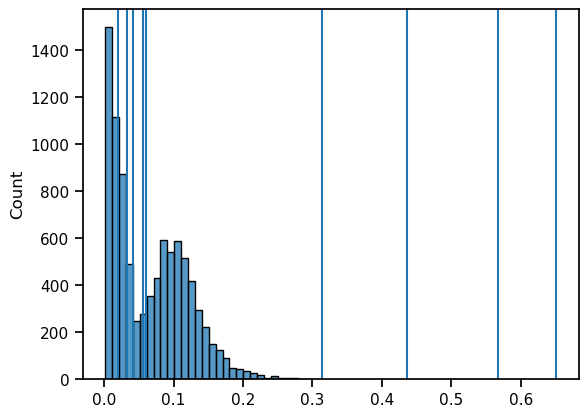

In [8]:
from scipy.stats import gaussian_kde
from scipy.integrate import quad

#sns.histplot(data = surrogate_distances)
dat_surr = surrogate_distances.copy()#[surrogate_distances>np.percentile(surrogate_distances, 90)]
sns.histplot(data = dat_surr, bins = 30)
kde = gaussian_kde(dat_surr)

def compute_area_kde(kde, d):
    # Compute CDF up to d_k
    cdf, _ = quad(kde, -np.inf, d)
    
    return min(cdf, 1.0) # Ensure CDF does not exceed 1 due to numerical integration

for ii in range(linkage_matrix.shape[0]):
    print(np.argmax(max_r2_cv) + internal_states[0] - ii, 1-compute_area_kde(kde, linkage_matrix[ii,2]))
    plt.axvline(linkage_matrix[ii,2])

In [ ]:
"""Script to find suitable initializations, due to a bug in Dynamax implementation of the EM."""
def try_seed(ii, mslr_true):
    SEED = jr.PRNGKey(ii)
    true_params, true_props = mslr_true.initialize(SEED)
    test_params, lps_true = mslr_true.fit_em(true_params, true_props, outputs, inputs = synthetic_data, num_iters = 50)
    # Generate a series of ground-truth states and emissions.
    true_states, emissions = mslr_true.sample(test_params, SEED, num_timesteps, inputs = synthetic_data)

    # Compute the marginal log probability of the emissions under the true model
    true_lp = mslr_true.marginal_log_prob(test_params, emissions, inputs = synthetic_data)


    # Now fit another model to the simulated data
    mslr = LinearRegressionHMM(num_states_true, covariate_dim, emission_dim)
    init_params, init_props = mslr.initialize(SEED)

    # To fit the model, give it a batch of emissions and a batch of corresponding inputs
    fit_params, lps = mslr.fit_em(init_params, init_props, emissions, inputs = synthetic_data, num_iters = 50)

    # Compute the most likely states
    most_likely_states = mslr.most_likely_states(fit_params, emissions, inputs = synthetic_data)

    return np.sum(np.isnan(lps))

# Evaluate MSLR models in parallel
mslr_true = LinearRegressionHMM(num_states_true, covariate_dim, emission_dim,
                            transition_matrix_concentration = concentration, 
                            transition_matrix_stickiness = stickiness)
mslr_list = [mslr_true for _ in range(100)]
pmap = acme.ParallelMap(try_seed, np.arange(100), mslr_list, 
                        n_inputs=100, setup_timeout=1)

with pmap as p:
    results = p.compute()
seed_nans = np.zeros(100)
for rr, fname in enumerate(results):
    with h5py.File(fname, 'r') as f:
        seed_nans[rr] = float(np.array(f['result_0']))

plt.bar(x = np.arange(100), height = seed_nans/50)
valid_seeds = np.where(seed_nans==0)[0]
np.save('ValidSeeds_Mouse_11112024.npy', valid_seeds)

In [5]:
import cmcrameri as cmc

# Now fit another model to the simulated data
mslr = LinearRegressionHMM(num_states_true, covariate_dim, emission_dim)
init_params, init_props = mslr.initialize(SEED)

# To fit the model, give it a batch of emissions and a batch of corresponding inputs
fit_params, lps = mslr.fit_em(init_params, init_props, emissions, inputs = inputs_train, num_iters = 50)

# Compute the most likely states
most_likely_states = mslr.most_likely_states(fit_params, emissions, inputs = inputs_train)

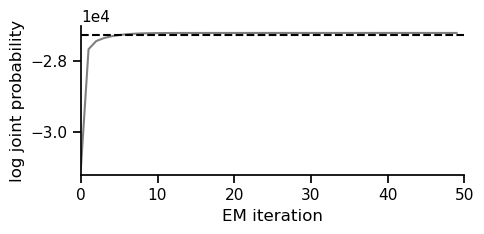

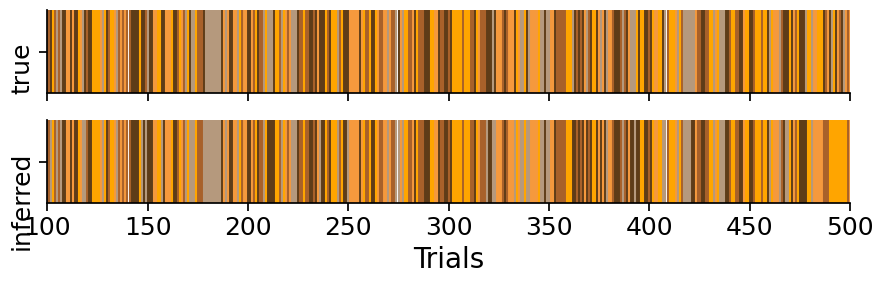

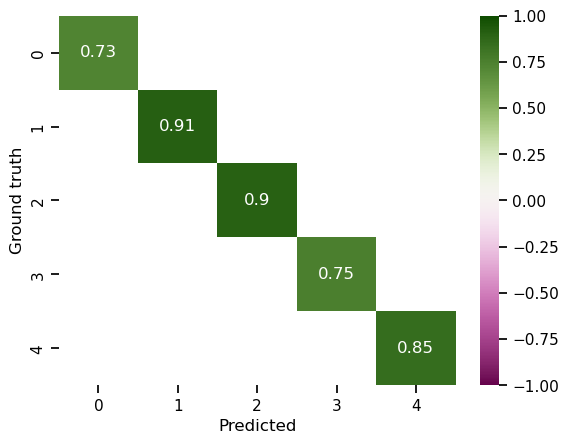

In [34]:
# Plot the log probability over EM iterations
plt.figure(figsize = (5,2.5))
plt.plot(lps, color = 'gray')
plt.plot([0, len(lps)], true_lp * jnp.ones(2), '--k')
plt.xlabel("EM iteration")
plt.ylabel("log joint probability")
plt.xlim([0, len(lps)])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
sns.despine()
plt.savefig('Results/LPS_synthetic_12112024.svg', transparent = True)

# Compare them to the true states
fig, ax = plt.subplots(nrows = 2, figsize = (9,3))
sns.despine()
states_all = np.arange(num_states_true)
titls = ["true", "inferred"]
stats = [true_states, most_likely_states]
xlim1 = 100
xlim2 = 500
for ii in range(2):
    for jj in states_all:
        idx = stats[ii] == jj
        if np.sum(idx):
            ax[ii].eventplot(np.where(idx)[0], color = cols_mouse[jj])
    if ii == 1:
        ax[ii].set_xlabel('Trials', fontsize = 20)
        ax[ii].set_xticks(ticks = np.arange(xlim1, xlim2 + 1, 50), labels = np.arange(xlim1, xlim2 + 1, 50).astype(int), fontsize = 18)

    else:
        ax[ii].set_xticklabels([])
    ax[ii].set_xlim(xlim1, xlim2)
    ax[ii].set_ylim(1, 1.5)
    ax[ii].set_yticks([1.25], [titls[ii]], fontsize = 18, rotation = 90)
plt.tight_layout()
plt.savefig('Results/StateExamples_synthetic_12112024.png', transparent = True, dpi = 300)
#plt.savefig('Results/StateExamples_synthetic_12112024.svg', transparent = True)


cors = find_similar_states(true_states, most_likely_states)
mask = np.abs(cors)<0.5
plt.figure()
sns.heatmap(cors, annot = True, vmin = -1, vmax = 1, cmap = 'cmc.bam', mask = mask)
plt.xlabel('Predicted')
plt.ylabel('Ground truth')
plt.savefig('Results/StateCorr_synthetic_12112024.svg', transparent = True)
